In [12]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time

data = pd.read_csv("../data/insurance.csv")

print(data.head())

data.shape



   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


(1338, 7)

In [13]:
print("\nValores nulos por columna:")
print(data.isnull().sum())
# No hay nulos en este dataset



Valores nulos por columna:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [14]:

encoding_maps = {}

le = LabelEncoder()
data['bmi_category_encoded'] = le.fit_transform(data['bmi'])
encoding_maps['bmi'] = dict(zip(le.classes_, le.transform(le.classes_)))

categorical_cols = ['sex', 'smoker', 'region']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

X_encoded = preprocessor.fit_transform(data.drop(['charges', 'bmi'], axis=1))

feature_names = (preprocessor.named_transformers_['cat']
                .get_feature_names_out(categorical_cols))
remaining_features = [col for col in data.columns 
                     if col not in categorical_cols + ['charges', 'bmi']]
all_feature_names = list(feature_names) + remaining_features

print("\nNombres de características:", all_feature_names)


Nombres de características: ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest', 'age', 'children', 'bmi_category_encoded']


In [11]:
X = X_encoded
y = data['charges'].values

# Normalizar las características numéricas
numeric_cols = ['age', 'bmi', 'children', 'bmi_category_encoded']
numeric_indices = [i for i, name in enumerate(all_feature_names) 
                  if any(col in name for col in numeric_cols)]

scaler = StandardScaler()
X[:, numeric_indices] = scaler.fit_transform(X[:, numeric_indices])



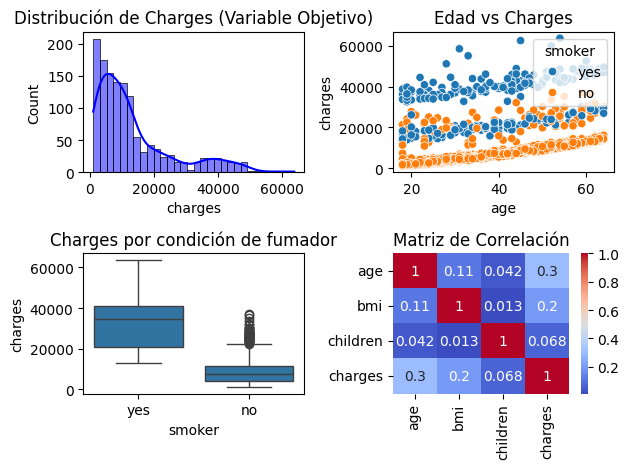

In [15]:

plt.subplot(2, 2, 1)
sns.histplot(data['charges'], kde=True, color='blue')
plt.title('Distribución de Charges (Variable Objetivo)')

plt.subplot(2, 2, 2)
sns.scatterplot(x='age', y='charges', data=data, hue='smoker')
plt.title('Edad vs Charges')

plt.subplot(2, 2, 3)
sns.boxplot(x='smoker', y='charges', data=data)
plt.title('Charges por condición de fumador')

plt.subplot(2, 2, 4)
numeric_data = data[['age', 'bmi', 'children', 'charges']]
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')

plt.tight_layout()
plt.show()



Con estas graficas podemos comprobar que la condicion de fumador

 tiene un alto impacto dentro de la metrica de "charges"


In [8]:
print("\nEstadísticas descriptivas de variables numéricas:")
print(data[['age', 'bmi', 'children', 'charges']].describe())

print("\nDistribución de variables categóricas:")
for col in ['sex', 'smoker', 'region', 'bmi']:
    print(f"\n{col}:")
    print(data[col].value_counts())


Estadísticas descriptivas de variables numéricas:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

Distribución de variables categóricas:

sex:
sex
male      676
female    662
Name: count, dtype: int64

smoker:
smoker
no     1064
yes     274
Name: count, dtype: int64

region:
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

bmi:
bmi
32.300    13
28.310     9
30.800     8
31.350     8
30.495     8
          ..
39.425     1
40.480     1
38.900     1
47.410     

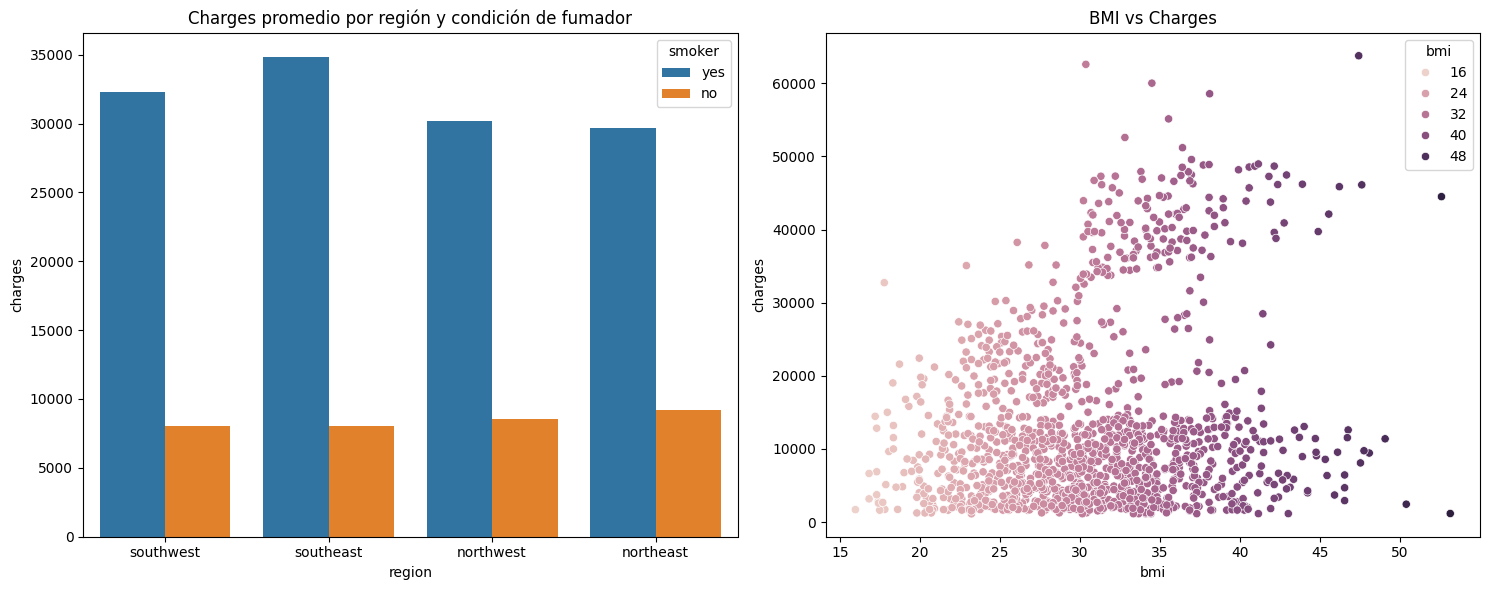

In [9]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='region', y='charges', hue='smoker', data=data, errorbar=None)
plt.title('Charges promedio por región y condición de fumador')

plt.subplot(1, 2, 2)
sns.scatterplot(x='bmi', y='charges', data=data, hue='bmi')
plt.title('BMI vs Charges')

plt.tight_layout()
plt.show()

In [10]:
print("\nForma de X:", X.shape)
print("Forma de y:", y.shape)


Forma de X: (1338, 8)
Forma de y: (1338,)


In [16]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("\nTamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (1070, 8)
Tamaño del conjunto de prueba: (268, 8)


In [18]:

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Bayesian": BayesianRidge(),
    "Lasso": Lasso(alpha=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVM": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,50), max_iter=2300, random_state=42, early_stopping=True)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    results.append({
        'Model': name,
        'Train MSE': mse_train,
        'Test MSE': mse_test,
        'Train R2': r2_train,
        'Test R2': r2_test,
    })
    
    print(f"{name} entrenado - R2 en test: {r2_test:.4f}")

results_df = pd.DataFrame(results)
print("\nResultados de todos los modelos:")
print(results_df.sort_values('Test R2', ascending=False))

OLS entrenado - R2 en test: 0.7837
Ridge entrenado - R2 en test: 0.7833
Bayesian entrenado - R2 en test: 0.7835
Lasso entrenado - R2 en test: 0.7837
KNN entrenado - R2 en test: 0.7534
Random Forest entrenado - R2 en test: 0.8696
SVM entrenado - R2 en test: 0.0351
MLP entrenado - R2 en test: 0.8389

Resultados de todos los modelos:
           Model     Train MSE      Test MSE  Train R2   Test R2
5  Random Forest  3.754018e+06  2.024789e+07  0.973991  0.869578
7            MLP  2.812328e+07  2.501806e+07  0.805151  0.838852
0            OLS  3.696909e+07  3.358402e+07  0.743864  0.783676
3          Lasso  3.696909e+07  3.358491e+07  0.743864  0.783670
2       Bayesian  3.696991e+07  3.361014e+07  0.743858  0.783508
1          Ridge  3.697213e+07  3.363578e+07  0.743843  0.783343
4            KNN  2.546351e+07  3.829064e+07  0.823579  0.753359
6            SVM  1.474115e+08  1.498036e+08 -0.021325  0.035073


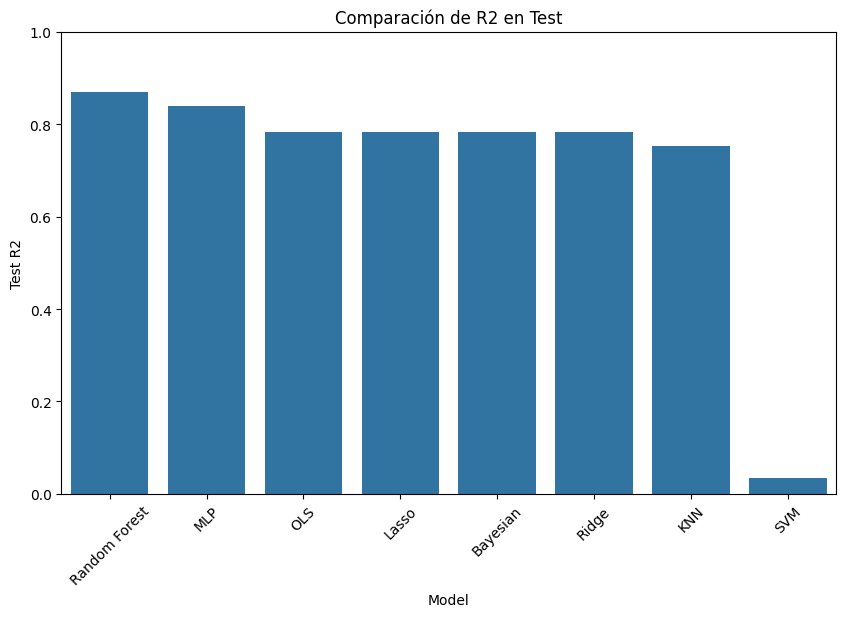

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Test R2', data=results_df.sort_values('Test R2', ascending=False))
plt.title('Comparación de R2 en Test')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


In [14]:
best_model_name = results_df.loc[results_df['Test R2'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"\nEl mejor modelo es: {best_model_name}")
print(f"R2 en test: {results_df.loc[results_df['Test R2'].idxmax(), 'Test R2']:.4f}")
print(f"MSE en test: {results_df.loc[results_df['Test R2'].idxmax(), 'Test MSE']:.2f}")


El mejor modelo es: Random Forest
R2 en test: 0.8696
MSE en test: 20247890.01
